In [18]:
%matplotlib inline
import math
import random
import sys
import matplotlib.pyplot as plt
import numpy as np
import pyNN.nest as p

In [19]:
def plot_digit(img_raw):
    img_raw = np.uint8(img_raw)
    plt.figure(figsize=(5,5))
    plt.imshow(np.reshape(img_raw,(28,28)))

In [20]:
def get_train_data():
    file_name = 'train-images.idx3-ubyte'
    f = open(file_name, "rb")
    magic_number, list_size, image_hight, image_width  = np.fromfile(f, dtype='>i4', count=4)
    train_x = np.fromfile(f, dtype='>u1', count=list_size*image_hight*image_width)
    train_x = np.reshape(train_x, (list_size,image_hight*image_width))
    f.close()
    
    file_name = 'train-labels.idx1-ubyte'
    f = open(file_name, "rb")
    magic_number, list_size = np.fromfile(f, dtype='>i4', count=2)
    train_y = np.fromfile(f, dtype='>u1', count=list_size*image_hight*image_width)
    f.close()
    
    return np.double(train_x), np.double(train_y)

In [21]:
def get_test_data():
    file_name = 't10k-images.idx3-ubyte'
    f = open(file_name, "rb")
    magic_number, list_size, image_hight, image_width  = np.fromfile(f, dtype='>i4', count=4)
    test_x = np.fromfile(f, dtype='>u1', count=list_size*image_hight*image_width)
    test_x = np.reshape(test_x, (list_size,image_hight*image_width))
    f.close()
    
    file_name = 't10k-labels.idx1-ubyte'
    f = open(file_name, "rb")
    magic_number, list_size = np.fromfile(f, dtype='>i4', count=2)
    test_y = np.fromfile(f, dtype='>u1', count=list_size*image_hight*image_width)
    f.close()
    
    return np.double(test_x), np.double(test_y)

In [22]:
def nextTime(rateParameter):
    return -math.log(1.0 - random.random()) / rateParameter
    #random.expovariate(rateParameter)
def poisson_generator(rate, t_start, t_stop):
    poisson_train = []
    if rate > 0:
        next_isi = nextTime(rate)*1000.
        last_time = next_isi
        while last_time < t_stop:
            poisson_train.append(last_time)
            next_isi = nextTime(rate)*1000.
            last_time += next_isi
    return poisson_train


In [23]:
def mnist_poisson_gen(image_list, image_height, image_width, max_freq, duration, silence):
    if max_freq > 0:
        for i in range(image_list.shape[0]):
            image_list[i] = image_list[i]/sum(image_list[i])*max_freq
    
    spike_source_data = x = [[] for i in range(image_height*image_width)]
    
    for i in range(image_list.shape[0]):
        t_start = i*(duration+silence)
        t_stop = t_start+duration
        for j in range(image_height*image_width):
            spikes = poisson_generator(image_list[i][j], t_start, t_stop)
            spike_source_data[j].extend(spikes)
            
    return spike_source_data

In [101]:
def spike_to_aerfile(spike_source_array, file_name):
    time_stamp = []
    neuron_id = []
    num_spike = len(spike_source_array)
    for i in range(num_spike):
        spikes = spike_source_array[i]
        #print spikes
        if spikes != []:
            time_stamp.extend(spikes)
            neuron_id.extend([i]*len(spikes))
            
    sort_index = sorted(range(len(time_stamp)), key=time_stamp.__getitem__)
    AllTs = np.uint32(np.ceil(np.array(time_stamp)[sort_index]*1000.)) #in mus
    neuron_id = np.array(neuron_id)[sort_index]
    image_size = 28
    y = neuron_id/image_size
    x = neuron_id%image_size
    
    AllAddr = np.uint32((x << 1) + (y << 1) * 128 + 1)
    print neuron_id, x, y,AllAddr
    f = open('abc.aedat','w')
    tok='#!AER-DAT'
    tok2='# This is a raw AE data file - do not edit'
    tok3='# Data format is int32 address, int32 timestamp (8 bytes total), repeated for each event'
    tok4='# Timestamps tick is 1 us'
    tok5='# created Tue Apr 29 11:36:59 CEST 2008'
    v=2.0

    f.write('%s'%tok)
    f.write('%1.1f\r\n'%v)
    f.write('%s\r\n'%tok2)
    f.write('%s\r\n'%tok3)
    f.write('%s\r\n'%tok4)
    f.write('%s\r\n'%tok5)

    bof=f.tell()
    #f.seek(-4,2)
    All = np.uint32(np.zeros((2,len(AllTs))))
    All[0] = AllAddr
    All[1] = AllTs
    All = np.reshape(np.transpose(All),(1,len(AllTs)+len(AllAddr)))[0]
    All = All.astype(dtype='>u4')
    All.tofile(f)
    f.close()

    return AllTs, AllAddr

In [104]:
random.seed( 10 )
train_x,train_y = get_train_data()
spike_source_data = mnist_poisson_gen(train_x[21:22], 28, 28, 8000, 1000, 100)
np.save('digit[0]',spike_source_data)

In [107]:
time_stamp, neuron_id = spike_to_aerfile(spike_source_data, '')

[158 511 186 ..., 455 295 426] [18  7 18 ...,  7 15  6] [ 5 18  6 ..., 16 10 15] [1317 4623 1573 ..., 4111 2591 3853]


In [108]:
import pyNN.nest as p
input_size = 28
dur_train = 100000
silence = 100
TEACH_rate = 50
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 1.0,
                   'tau_syn_I': 1.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }
p.setup(timestep=1.0, min_delay=1.0, max_delay=3.0)
pop_input = p.Population(input_size*input_size, p.IF_curr_exp, cell_params_lif)
pop_output = p.Population(1, p.IF_curr_exp, cell_params_lif)
pop_teach = p.Population(1,p.SpikeSourcePoisson,{'rate' : TEACH_rate,
                                                   'start' : 0,
                                                   'duration' :dur_train})

In [109]:
index_run = [1]
ImagePoission = list()
for i in range(len(index_run)):
    pop = p.Population(input_size*input_size, p.SpikeSourceArray,
                                                  {'spike_times' : []})
    for j in range(input_size*input_size):
        pop[j].spike_times = spike_source_data[j]
    ImagePoission.append(pop)

In [110]:
ee_connector = p.OneToOneConnector(weights=3.0)
for i in range(len(index_run)):
    p.Projection(ImagePoission[i], pop_input, ee_connector, target='excitatory')

In [111]:
p.Projection(pop_teach, pop_output, ee_connector, target='excitatory')
print pop_teach

In [112]:
weight_max = 1.3
stdp_model = p.STDPMechanism(
    timing_dependence=p.SpikePairRule(tau_plus=10.0, tau_minus=10.0),
    weight_dependence=p.MultiplicativeWeightDependence(w_min=0.0, w_max=weight_max, A_plus=0.01, A_minus=0.01)
)

In [113]:
stdp_weight = 0.0
proj_stdp = p.Projection(
        pop_input, pop_output, p.AllToAllConnector(weights = stdp_weight),
        synapse_dynamics=p.SynapseDynamics(slow=stdp_model)
)

In [114]:
ImagePoission[0].record()
p.run(len(index_run)*(dur_train+silence))
post = proj_stdp.getWeights(format='array',gather=False)

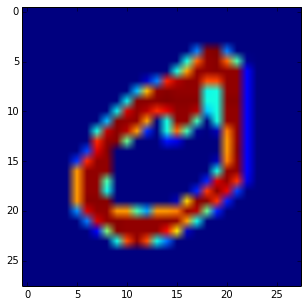

In [115]:
def plot_digit(img_raw):
    plt.figure(figsize=(5,5))
    plt.imshow(np.reshape(img_raw,(28,28)))
plot_digit(train_x[21])

In [116]:
def plot_spikes(spikes, title):
    if spikes is not None:
        plt.figure(figsize=(15, 5))
        plt.plot([i[1] for i in spikes], [i[0] for i in spikes], ".")
        plt.xlabel('Time/ms')
        plt.ylabel('spikes')
        plt.title(title)

    else:
        print "No spikes received"

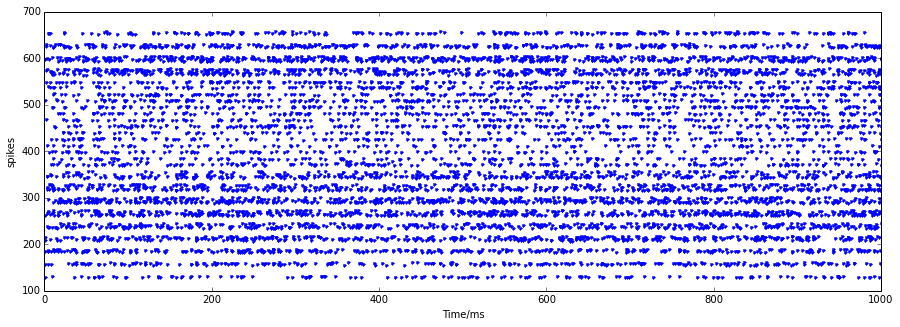

In [136]:
spikes = ImagePoission[0].getSpikes(compatible_output=True)
plot_spikes(spikes,'')

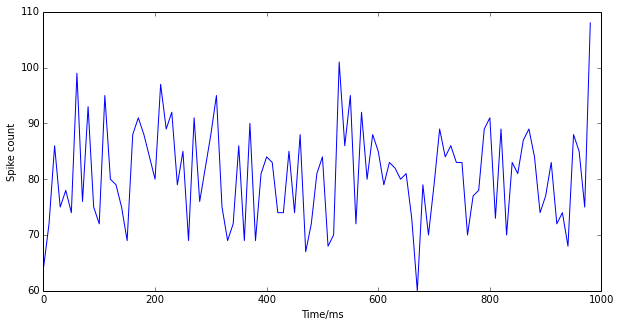

In [139]:
np.histogram(spikes[:, 1],bins=range(0,1000,1))
plt.figure(figsize=(10,5))
plt.plot(a[1][:-1],a[0])
plt.xlabel('Time/ms')
plt.ylabel('Spike count')
#plot_spikes(spikes, "")

In [131]:
print a[0].shape, a[1].shape

(99,) (100,)
